In [1]:
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# import data
centroid_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_REGISTERED.csv")
census_data = data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08119_stl_city.csv")

In [3]:
# clean census data

warnings. filterwarnings('ignore')

# Only keep important columns
census_data = census_data[['location','label','estimate','moe']]
census_data['label'] = census_data['label'].str.replace('Estimate', '').str.replace('Total', '').str.replace('!!', '').str.replace(':', '')
census_data['location'] = census_data['location'].str.replace('; St. Louis city; Missouri','')

# Filter out aggregate columns
all_totals = census_data[census_data['label']=='']
trans_totals_mask = ~census_data['label'].astype(str).str.contains('[$]')
trans_totals = census_data.loc[trans_totals_mask][1:]
income_totals = census_data[census_data['label'].str.startswith("$")]
not_to_include = pd.concat([trans_totals, income_totals, all_totals])
merged_df = pd.merge(census_data, not_to_include, how='left', indicator=True)
no_totals = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])[1:]
split_data = no_totals['label'].str.split('$', 1, expand=True)
no_totals[['transportation', 'income']] = split_data
no_totals.drop(columns=['label'], inplace=True)
no_totals['income'] = '$' + no_totals['income']
from_this = no_totals['income'].unique()
to_this = [1, 10000, 15000, 25000, 35000, 50000, 65000, 75000]
no_totals['avg income'] = no_totals['income'].replace(from_this, to_this)
clean_census_data = no_totals

In [4]:
# Group by census tract and mode of transportation
by_tract_trans = clean_census_data.groupby(['location','transportation'])['estimate'].sum()

# Find percentage of people who take public transport in each tract
tract_pops = clean_census_data.groupby('location', as_index = False)['estimate'].sum()['estimate'].tolist()
public_transit_pops = clean_census_data[clean_census_data['transportation']=='Public transportation (excluding taxicab)'].groupby(['location','transportation'], as_index = False)['estimate'].sum()['estimate'].tolist()

pct_public_trans = []
for i in range(len(tract_pops)):
    pct_public_trans.append(public_transit_pops[i]/tract_pops[i])

# Add percentages back in to groupby
by_tract = clean_census_data.groupby('location', as_index = False)['estimate'].sum()
by_tract['public transport count'] = public_transit_pops
by_tract['public transport %'] = pct_public_trans

In [5]:
# merge census tract location data with census data

centroid_locations_small = centroid_locations[['NAMELSAD','INTPTLAT','INTPTLON']]
centroid_locations_small = centroid_locations_small.rename(columns = {"NAMELSAD": "location", "INTPTLAT" : "lat", "INTPTLON" : "lon"})

full_data = by_tract.merge(centroid_locations_small, on='location')
full_data.head()

,location,estimate,public transport count,public transport %,lat,lon
0,Census Tract 1011,1039,31,0.029836,38.554718,-90.273620
1,Census Tract 1012,1921,11,0.005726,38.561824,-90.274863
2,Census Tract 1013,2161,35,0.016196,38.566560,-90.264211
3,Census Tract 1014,1502,95,0.063249,38.562243,-90.253522
4,Census Tract 1015,1318,32,0.024279,38.548544,-90.264511


In [6]:
# weighted k-means function!

def weighted_kmeans(data, k):
    n = len(data[0]) # number of census tracts
    stop = False
    labels = np.zeros(n) # assigns each centroid to a cluster
    centroids = np.zeros([k, 2]) # centroid for each cluster
    count = 0

    # randomly initialize centroids to be somewhere in the STL City region (between min and max of data)
    for i in range(k):
        centroids[i][0] = round(random.uniform(np.min(data[0]), np.max(data[0])), 6)
        centroids[i][1] = round(random.uniform(np.min(data[1]), np.max(data[1])), 6)
        
    # iterate until labels do not change (or at least twice)
    while stop == False or count < 2:
        count = count + 1
        old_labels = labels

        # Calculating labels by finding nearest centroid for each census tract
        for i in range(n): # for each tract
            closest_distance = float('inf')
            tract_center = np.array([data[0][i], data[1][i]])
            for j in range(k): # for each centroid/cluster
                centroid = np.array([centroids[j][0], centroids[j][1]])
                dist = np.linalg.norm(tract_center - centroid)
                if (dist < closest_distance):
                    closest_distance = dist
                    labels[i] = j

        # Check if any of the labels changed
        all_same = True
        for i in range(n):
            if (labels[i] != old_labels[i]):
                all_same = False
        if all_same == True:
            stop = True

        # updating centroid locations as the (weighted?) mean of each census tract in its cluster
        new_centroids = np.zeros([k,2])
        for i in range(k): # for each cluster
            weights = []
            cluster = []
            for j in range(n): # for each tract
                if (labels[j] == i):
                    weights.append(data[2][j]) # weights will not all sum to 1 (different number in each cluster)
                    cluster.append(np.array([data[0][j], data[1][j]]))

            new_x = [point[0] for point in cluster]
            new_y = [point[1] for point in cluster]
            normalized_weights = np.array(weights)/np.sum(weights)

            if len(new_x) > 1: # if there are points in the cluster
                new_centroids[i][0] = np.dot(normalized_weights, new_x)
                new_centroids[i][1] = np.dot(normalized_weights, new_y)
            else:
                new_centroids[i][0] = centroids[i][0]
                new_centroids[i][1] = centroids[i][1]

        centroids = new_centroids
        
        return centroids, labels

In [7]:
# data is coordinates of tracts and weights
data = [list(full_data['lon']), list(full_data['lat']), list(full_data['public transport count'])]
k = 12

centroids, labels = weighted_kmeans(data, k)

print(f'Final centroids: {centroids} \n')

print(f'Final centroid labels: {labels} \n')
print(f'{len(np.unique(labels))} out of {k} total clusters have tracts in them!')

Final centroids: [[-90.22325731  38.59638024]
 [-90.21522691  38.67323866]
 [-90.23065493  38.71709911]
 [-90.2799138   38.66042387]
 [-90.27033432  38.61134127]
 [-90.23219466  38.58150175]
 [-90.298492    38.70915   ]
 [-90.25181467  38.57617327]
 [-90.297761    38.69888   ]
 [-90.24664674  38.68276438]
 [-90.23108896  38.63969298]
 [-90.19667384  38.63156697]] 

Final centroid labels: [ 7.  7.  7.  7.  7.  7.  7.  4.  7.  7.  7.  4.  4.  4.  4.  4.  4.  4.
  3.  3.  3.  3.  3.  3.  3.  3.  9.  9.  3.  9.  9.  9.  9.  9.  9.  9.
  2.  2.  1.  1.  9.  9. 10.  1.  1. 10.  9. 10.  4.  3. 10.  4.  4.  4.
  4.  4.  4.  4.  4.  7.  7.  7.  5.  5.  4.  4.  4.  7.  7.  4.  4.  4.
 10.  4.  4.  4. 10. 10. 10.  1. 10. 10. 10.  0.  5.  0.  0.  0. 11. 11.
 11. 11. 11.  4.  9.  2. 10.  4. 10. 11. 11.  0. 10. 10.] 

10 out of 12 total clusters have tracts in them!


In [8]:
full_data['cluster'] = labels
full_data.head()

,location,estimate,public transport count,public transport %,lat,lon,cluster
0,Census Tract 1011,1039,31,0.029836,38.554718,-90.273620,7.0
1,Census Tract 1012,1921,11,0.005726,38.561824,-90.274863,7.0
2,Census Tract 1013,2161,35,0.016196,38.566560,-90.264211,7.0
3,Census Tract 1014,1502,95,0.063249,38.562243,-90.253522,7.0
4,Census Tract 1015,1318,32,0.024279,38.548544,-90.264511,7.0


Text(0.5, 1.0, 'Centroid Locations')

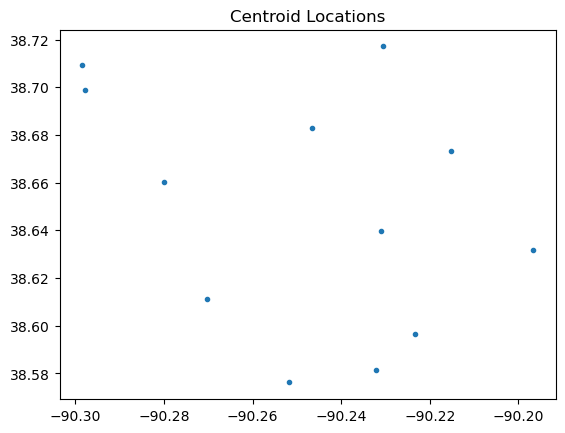

In [9]:
longs = [i[0] for i in centroids]
lats = [i[1] for i in centroids]
plt.plot(longs, lats, '.')
plt.title('Centroid Locations')

In [28]:
cluster_centroids = pd.DataFrame(data = centroids, columns = ["long", "lat"])
cluster_centroids['label'] = [i for i in range(len(cluster_centroids))]
cluster_centroids['size'] = [8 for i in range(len(cluster_centroids))]

fig = px.scatter_mapbox(cluster_centroids,
                        lat='lat',
                        lon='long',
                        color='label',
                        size='size',
                        zoom=12,
                        height=750)
fig.update_layout(mapbox_style="open-street-map")


In [9]:
# next idea: add a new column to the dataframe for "distance to cluster centroid"
# then, we can run both weighted and unweighted k-means and see how helpful weighting by population was

# things to weight by:
# race (balkan population)
# income
# communities of interest
# road size/infastructure in neighborhoods (used to be hubs)
# cost?? governments typically optimize on cost, but we want to optimize on equity issues instead

# ensemble mathods for a third method??
# dual problem with edges that encode actual proximity in terms of travel, not lat/lon (i.e. opposite sides of 64)
# apple maps walking distance between centroids

# linear programming - enforcing n/s line
# 1. global bound on longitude
# 2. penalty term on variance of longitude
# 3. penalty term for something about colinearity
# error sounds best --> try different penalties and see what happens
# actually two things: north-southness and linearity
# linearity is like an industrial constraint, but then there's also a slope constraint to force north-southness

# interesting ben tools and rabbit holes to come!